# NN - Домашнее задание 4

- получить эмбединги любой трансформенной моделью (например, BERT) для каждого предложения для train данных
- на полученных эмбедингах построить любую модель или применить любой алгоритм для классификации на целевую переменную из соревнования;
- посчитать эмбединги для каждого предложения для test данных (аналогично как для train);
- сделать предсказание для test данных на посчитанных эмбеддингах;
- сделать сабмит, чтобы узнать свою метрику качества

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, TensorDataset  

from transformers import BertTokenizer, BertModel

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

### Подготовка данных

In [2]:
df_train = pd.read_csv('/kaggle/input/nn-text/train.csv')
df_test = pd.read_csv('/kaggle/input/nn-text/test.csv')
sample_submission = pd.read_csv('/kaggle/input/nn-text/sample_submission.csv')

In [3]:
df_train = df_train.drop('Unnamed: 0', axis = 1)
df_train = df_train[df_train['Rating'] < 6]

In [4]:
df_train.shape

(14338, 2)

In [5]:
df_train.head()

,Review,Rating
0,foliage silhouette perfect european getaway ho...,4
1,characterized recommendng clean safe hotel hus...,4
2,"seaweed avoidwe spectacular, booked trip bj wh...",5
3,"week__ç_é_ doona ca n't wait return, hotel mag...",5
4,choppy marched super budget hotel hubby stayed...,5


In [6]:
df_test.head()

,index,Review
0,0,"saefood bubbas want iwant ro riu wow, riu bamb..."
1,1,raging she__ç_éö enjoyably different just retu...
2,2,"boading terrifying best vacation, husband went..."
3,3,blended enthusastic location location location...
4,4,peptol insulated love hk good hotel stay noise...


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Получение эмбеддингов

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained("bert-base-uncased")

model.to(device)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [9]:
print(' Original: ', df_train['Review'][:1], '\n')

print('Tokenized: ', tokenizer.tokenize(df_train['Review'][:1].item()), '\n')

 Original:  0    foliage silhouette perfect european getaway ho...
Name: Review, dtype: object 

Tokenized:  ['foliage', 'silhouette', 'perfect', 'european', 'get', '##away', 'hotel', 'chi', '##c', 'elegant', 'friendly', 'professional', 'staff', ',', 'room', 'small', 'well', '-', 'appointed', 'good', 'use', 'limited', 'space', ',', 'bed', 'comfortable', 'du', '##vet', 'nice', 'pillows', ',', 'complaint', 'room', 'reading', 'lights', 'bed', 'did', 'n', "'", 't', 'work', ',', 'be', '##ware', 'breakfast', ',', 'expensive', ',', 'mistakenly', 'assumed', 'breakfast', 'included', 'room', 'thought', 'taken', 'morning', 'coffee', '##s', 'meals', ',', 'good', 'breakfast', ',', 'internet', 'fee', '5', 'euro', '5', 'minutes', 'crazy', 'not', 'choice', 'wanted', 'confirm', 'return', 'flight', 'home', ',', 'room', 'offers', 'free', 'wireless', ',', 'recommend', 'hotel', 'just', 'mind', '##ful', 'extra', 'charges', ',', 'ca', 'n', "'", 't', 'beat', 'location', ',', 'members'] 



In [10]:
def embed_bert_cls(text, model, tokenizer):
    # Токенизация текста
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors='pt')

    # Перемещение данных на устройство модели (CPU или GPU)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    # Отключение вычисления градиентов для экономии памяти
    with torch.no_grad():
        model_output = model(**inputs)

    # Извлечение эмбеддингов из последнего скрытого состояния
    embeddings = model_output.last_hidden_state[:, 0, :]

    # Нормализация эмбеддингов
    embeddings = torch.nn.functional.normalize(embeddings)

    # Возвращаем эмбеддинги в виде numpy массива
    return embeddings[0].cpu().numpy()

In [11]:
train_embs = [embed_bert_cls(i, model, tokenizer) for i in tqdm(df_train['Review'].values)]

100%|██████████| 14338/14338 [03:54<00:00, 61.14it/s]


In [12]:
test_embs = [embed_bert_cls(i, model, tokenizer) for i in tqdm(df_test['Review'].values)]

100%|██████████| 6148/6148 [01:40<00:00, 61.46it/s]


### Обучение и валидация


In [13]:
X_train, X_val, y_train, y_val = train_test_split(train_embs, df_train['Rating'], test_size=0.2, random_state=42, stratify=df_train['Rating'])

In [14]:
y_train = y_train - 1
y_val = y_val - 1

In [15]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)

In [16]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)

# Определение простой нейронной сети
class SimpleNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [17]:
model = SimpleNN(input_dim=X_train.shape[1], num_classes=5)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [18]:
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [19]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch in train_loader:
        inputs, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

Epoch [1/10], Loss: 1.2334
Epoch [2/10], Loss: 1.0627
Epoch [3/10], Loss: 1.0085
Epoch [4/10], Loss: 0.9847
Epoch [5/10], Loss: 0.9694
Epoch [6/10], Loss: 0.9614
Epoch [7/10], Loss: 0.9497
Epoch [8/10], Loss: 0.9445
Epoch [9/10], Loss: 0.9378
Epoch [10/10], Loss: 0.9327


In [20]:
model.eval()

with torch.no_grad():
    val_outputs = model(X_val)
    val_loss = criterion(val_outputs, y_val).item()
    _, y_pred = torch.max(val_outputs, 1)
    accuracy = accuracy_score(y_val.numpy(), y_pred.numpy())
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {accuracy:.4f}')

Validation Loss: 0.9574, Validation Accuracy: 0.5704


### Предикты для test

In [21]:
X_train = np.array(train_embs)
y_train = df_train['Rating'] - 1 
y_train = np.array(y_train)

X_train = torch.tensor(train_embs, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

X_test = torch.tensor(test_embs, dtype=torch.float32)

/tmp/ipykernel_35/1656846503.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:261.)
  X_train = torch.tensor(train_embs, dtype=torch.float32)


In [22]:
# Создание DataLoader для обучения
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [23]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch in train_loader:
        inputs, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

Epoch [1/10], Loss: 0.9306
Epoch [2/10], Loss: 0.9291
Epoch [3/10], Loss: 0.9240
Epoch [4/10], Loss: 0.9183
Epoch [5/10], Loss: 0.9141
Epoch [6/10], Loss: 0.9110
Epoch [7/10], Loss: 0.9082
Epoch [8/10], Loss: 0.9044
Epoch [9/10], Loss: 0.9005
Epoch [10/10], Loss: 0.8994


In [24]:
model.eval()
y_pred = 0

with torch.no_grad():
    test_outputs = model(X_test)
    _, y_pred = torch.max(test_outputs, 1)

In [25]:
y_pred.tolist()
y_pred = [x.tolist() + 1 for x in y_pred]

In [26]:
sample_submission['Rating'] = y_pred

In [27]:
sample_submission.to_csv('hw__4.csv', index=False)

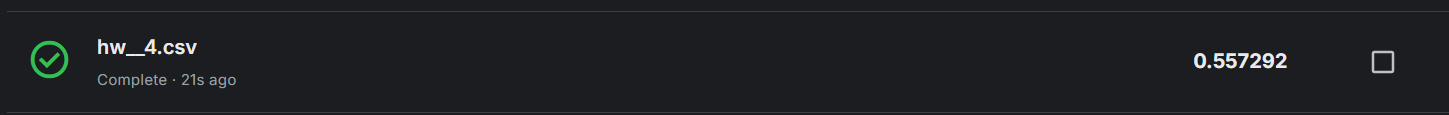